In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import torch
import torch.nn as nn
import datasets
import transformers
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [3]:
data = datasets.load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset")
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data, test_data = data["train"], data["test"]
train_data

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 5994
})

2695
a mid-size bird that has an orange bill and feet, and has a white belly and a brown head.
a large bird with a gray and white body, brown head and orange bill, tarsus and feet.
this is a bird with a white belly, brown head and orange feet.
this bird has a white belly and breast, with a long neck and long wide bill.
this bird is white, grey, and brown in color with a red beak, and black eye rings.
this bird is white with grey and red and has a long, pointy beak.
this is a very large bird with webbed feet and a long body and head and large wings and beak.
a waterbird with a white breast, grey back and neck, brown head, red legs and long, flat, red bill.
this bird is white and brown in color, with a flat orange beak.
a bird with a flat bill, a white abdomen and wings, and orange legs.



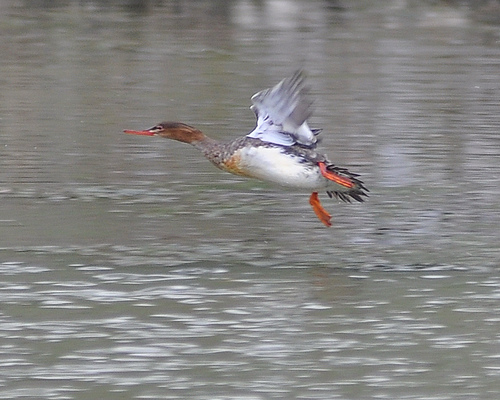

89


In [4]:
def match_random_sample():
    n = np.random.randint(0, len(train_data))
    print(n)
    print(train_data[n]["description"])
    train_data[n]["image"].show()
    print(train_data[n]["label"])


match_random_sample()

In [5]:
from transformers import BertTokenizer, BertModel
from transformers import ViTImageProcessor, ViTForImageClassification

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
image_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
image_model.classifier = nn.Identity()
image_model = image_model.to(device)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")
text_model = text_model.to(device)


embedding_sim = nn.CosineSimilarity()


def batch_image_embed(batch):
    input_data = processor(images=batch, return_tensors="pt")
    input_data = input_data.to(device)
    return image_model(**input_data).logits


def batch_text_embed(batch):
    encoded_input = tokenizer(batch, return_tensors="pt", padding="max_length")
    encoded_input = encoded_input.to(device)
    output = text_model(**encoded_input).last_hidden_state
    return output.mean(dim=1)

In [6]:
img = train_data[0]['image']
text = train_data[0]['description']

img_e = batch_image_embed(img)
text_e = batch_text_embed(text)

img_e.shape, text_e.shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [7]:
for param in image_model.parameters():
    param.requires_grad = False

for param in text_model.parameters():
    param.requires_grad = False

In [8]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(768 * 2, 768) # 2 * d -> 768
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(768, 200) # 768 -> num_class
    def forward(self, images, texts):
        img_e = batch_image_embed(images)
        text_e = batch_text_embed(texts)
        MLP_input = torch.cat((img_e, text_e), dim=1)
        x = self.linear1(MLP_input)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [9]:
def convert_img(elem):
    return elem['image'].mode == "RGB"


train_data = train_data.shuffle()
train_data = train_data.filter(convert_img, num_proc=16)

ids = np.array(range(len(test_data)))
rand_ids = np.random.choice(ids, size=1000, replace=False)
val_data = test_data.select(rand_ids)
val_data = val_data.filter(convert_img, num_proc=16)
val_data

Filter (num_proc=16):   0%|          | 0/5994 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'description', 'label', 'file_name'],
    num_rows: 999
})

In [10]:
lin_model = LinearModel().to(device)
loss_fun = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.AdamW(lin_model.parameters(), lr)
epoch_num = 3
batch_size = 16

In [11]:
def validate():
    loss_hist = []
    true_preds = 0
    sum_loss = 0
    processed_samples = 0
    progress = tqdm(range(0, len(val_data) - batch_size, batch_size))
    with torch.no_grad():
        for j in progress:
            batch = val_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
    print(f"Mean val Loss: {sum_loss / (processed_samples / batch_size)}")
    print(f"Val accuracy: {true_preds / processed_samples}")
    print(processed_samples)

In [12]:
def train():
    loss_hist = []
    for i in range(epoch_num):
        true_preds = 0
        sum_loss = 0
        processed_samples = 0
        progress = tqdm(range(0, len(train_data) - batch_size, batch_size))
        for j in progress:
            optimizer.zero_grad()

            batch = train_data[j:j+batch_size]
            images, texts, labels, _ = batch.values()
            labels = torch.tensor(labels, device=device)

            output = lin_model(images, texts)
            loss = loss_fun(output, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(output, dim=1)
            correct = torch.sum(preds == labels).item()
            true_preds += correct
            sum_loss += loss.item()
            loss_hist.append(loss.item())
            progress.set_description(f"Loss: {loss.item():.3f}, Correct: {correct}")
            processed_samples += batch_size
        print(f"Mean epoch Loss: {sum_loss / (processed_samples / batch_size)}")
        print(f"Epoch accuracy: {true_preds / processed_samples}")
        print(processed_samples)
        validate()
    return loss_hist

loss_hist = train()

  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 1.7547615713136082
Epoch accuracy: 0.5574866310160428
5984


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 0.9100314681568453
Val accuracy: 0.7379032258064516
992


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 0.5858465241278238
Epoch accuracy: 0.8111631016042781
5984


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 0.7480286821242301
Val accuracy: 0.7883064516129032
992


  0%|          | 0/374 [00:00<?, ?it/s]

Mean epoch Loss: 0.34606099288591885
Epoch accuracy: 0.8913770053475936
5984


  0%|          | 0/62 [00:00<?, ?it/s]

Mean val Loss: 0.7843321314261805
Val accuracy: 0.7943548387096774
992


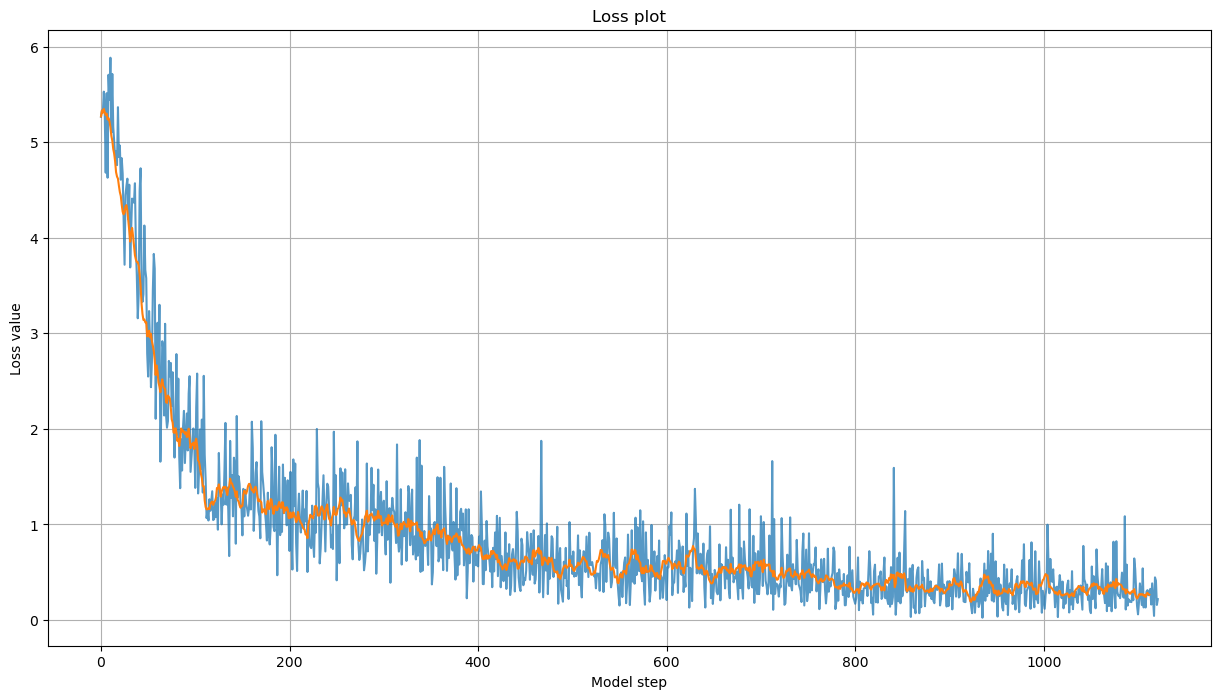

In [13]:
import matplotlib.pyplot as plt
# Smoothing function using a moving average
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

# Define the window size for the moving average
window_size = 10

# Smooth the loss data using the moving average
smoothed_loss = moving_average(loss_hist, window_size)


plt.figure(figsize=(15, 8))
plt.plot(loss_hist, alpha=0.75)
plt.plot(smoothed_loss)
plt.grid()
plt.title('Loss plot')
plt.xlabel('Model step')
plt.ylabel('Loss value')
plt.show()